In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n_d=100

In [ ]:
t_actual=np.array(np.linspace(0,20,n_d))
print(t_actual)

[ 0.          0.2020202   0.4040404   0.60606061  0.80808081  1.01010101
  1.21212121  1.41414141  1.61616162  1.81818182  2.02020202  2.22222222
  2.42424242  2.62626263  2.82828283  3.03030303  3.23232323  3.43434343
  3.63636364  3.83838384  4.04040404  4.24242424  4.44444444  4.64646465
  4.84848485  5.05050505  5.25252525  5.45454545  5.65656566  5.85858586
  6.06060606  6.26262626  6.46464646  6.66666667  6.86868687  7.07070707
  7.27272727  7.47474747  7.67676768  7.87878788  8.08080808  8.28282828
  8.48484848  8.68686869  8.88888889  9.09090909  9.29292929  9.49494949
  9.6969697   9.8989899  10.1010101  10.3030303  10.50505051 10.70707071
 10.90909091 11.11111111 11.31313131 11.51515152 11.71717172 11.91919192
 12.12121212 12.32323232 12.52525253 12.72727273 12.92929293 13.13131313
 13.33333333 13.53535354 13.73737374 13.93939394 14.14141414 14.34343434
 14.54545455 14.74747475 14.94949495 15.15151515 15.35353535 15.55555556
 15.75757576 15.95959596 16.16161616 16.36363636 16

In [3]:
omega=0.5*np.pi
phase=0
x0=0

In [4]:
#True_solution
def spring_block_system(t):
    return np.sin(omega*t+phase)

In [ ]:
#Noise_addition to True_Solution
np.random.seed(0)
exact_data=spring_block_system(t_actual)
noise_level=0.04
noisy_data=exact_data+noise_level*np.random.randn(n_d)

In [6]:
print(noisy_data)

[ 0.07056209  0.32803973  0.63205745  0.90421168  1.02960456  0.96078301
  0.98300436  0.78970755  0.56293111  0.2981565  -0.02596619 -0.2838492
 -0.58771748 -0.82770285 -0.94608763 -0.98552037 -0.8743847  -0.78435279
 -0.52811811 -0.28531182 -0.03869567  0.3978072   0.67736506  0.82003883
  1.06260175  0.93868015  0.92418463  0.74826222  0.57498856  0.27908488
 -0.08885815 -0.38580403 -0.70228043 -0.94525726 -0.99271893 -0.98758451
 -0.86042037 -0.68649651 -0.50168981 -0.20134335  0.08465033  0.37299419
  0.6218282   0.95948438  0.96442167  0.97229847  0.84588196  0.74379379
  0.39367061  0.14949178 -0.19382006 -0.44275042 -0.73312638 -0.94321906
 -0.99094873 -0.96767448 -0.87879267 -0.67798014 -0.4551678  -0.1411021
  0.16235283  0.47181461  0.70206586  0.84058069  1.00093551  0.96273121
  0.80081747  0.68528029  0.3646386   0.09713386 -0.19114691 -0.50851808
 -0.71017355 -0.97174733 -0.98076111 -0.99920397 -0.88455732 -0.6659416
 -0.38412456 -0.06117731  0.20454199  0.57667388  0.79

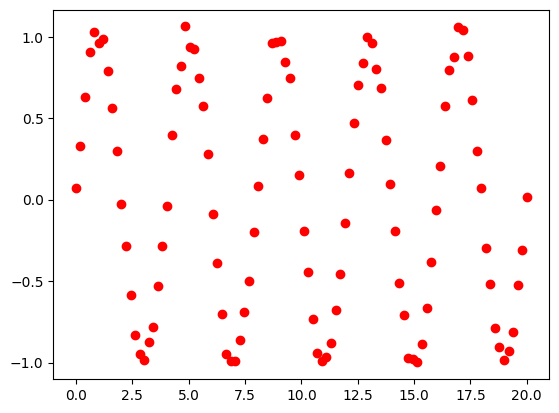

In [7]:
plt.scatter(t_actual,noisy_data,c="red")

In [8]:
import torch
import torch.nn as nn
t_tensor=torch.tensor(t_actual,dtype=torch.float32).view(-1,1)
data_tensor=torch.tensor(noisy_data,dtype=torch.float32).view(-1,1)

In [9]:
class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [10]:
#Model building alongwith forward_propagation
class PINN(nn.Module):
    def __init__(self,n_hidden=40):
        super(PINN,self).__init__()
        self.net=nn.Sequential(
            nn.Linear(1,n_hidden),
            # SinActivation(),
            nn.Tanh(),
            nn.Linear(n_hidden,n_hidden),
            # SinActivation(),
            nn.Tanh(),
            nn.Linear(n_hidden,n_hidden),
            # SinActivation(),
            nn.Tanh(),
            nn.Linear(n_hidden,1)
        )
    def forward(self,t):
        return self.net(t)
model=PINN(n_hidden=40)   

In [11]:
#Defining derivative for Auto differentiator in the developed Model
def derivative(x,y):
    return torch.autograd.grad(
        x , y,
        grad_outputs=torch.ones_like(x),
        create_graph=True,
        allow_unused=True
    )[0]

In [12]:
# Defining individual loss function (ODE, Initial Condition, Data)
def ODE_loss(model,t):
    t.requires_grad_(True)
    x_pred=model(t)
    dx_dt_pred=derivative(x_pred,t)
    dx_dt_actual=torch.sin(omega*t+phase)
    loss_ode=torch.mean((dx_dt_pred-dx_dt_actual)**2)
    return loss_ode
def IC_loss(model):
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    x0_pred = model(t0)
    return (x0_pred - x0).pow(2).mean()
def data_loss(model,x_data,t_data):
    x_pred=model(t_data)
    return torch.mean((x_data-x_pred)**2)


In [13]:
#Hyperparameter tuning and optimizer selection
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
c_ode=2.0
c_ic=2.0
c_data=2.0
num_epochs = 30000
print_every = 2000

In [ ]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    l_data = data_loss(model, data_tensor, t_tensor)
    l_ode = ODE_loss(model,t_tensor)
    l_ic = IC_loss(model)
    loss =c_ode*l_ode/n_d + c_ic * l_ic
    loss.backward()
    optimizer.step()
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")
# optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=20000)
# optimizer_lbfgs.step(lambda: loss)

Epoch 2000/30000, Total Loss = 0.006091, Data Loss = 1.135082, ODE Loss = 0.003035, IC Loss = 0.000010
Epoch 4000/30000, Total Loss = 0.009095, Data Loss = 1.028669, ODE Loss = 0.004411, IC Loss = 0.000137
Epoch 6000/30000, Total Loss = 0.001268, Data Loss = 1.054239, ODE Loss = 0.000630, IC Loss = 0.000004
Epoch 8000/30000, Total Loss = 0.001551, Data Loss = 1.047477, ODE Loss = 0.000775, IC Loss = 0.000000
Epoch 10000/30000, Total Loss = 0.003765, Data Loss = 1.080003, ODE Loss = 0.001832, IC Loss = 0.000051
Epoch 12000/30000, Total Loss = 0.002697, Data Loss = 1.112280, ODE Loss = 0.001316, IC Loss = 0.000032
Epoch 14000/30000, Total Loss = 0.001723, Data Loss = 1.104310, ODE Loss = 0.000832, IC Loss = 0.000030
Epoch 16000/30000, Total Loss = 0.001579, Data Loss = 1.108620, ODE Loss = 0.000774, IC Loss = 0.000016
Epoch 18000/30000, Total Loss = 0.002577, Data Loss = 1.122964, ODE Loss = 0.001240, IC Loss = 0.000049
Epoch 20000/30000, Total Loss = 0.002719, Data Loss = 1.074684, ODE 

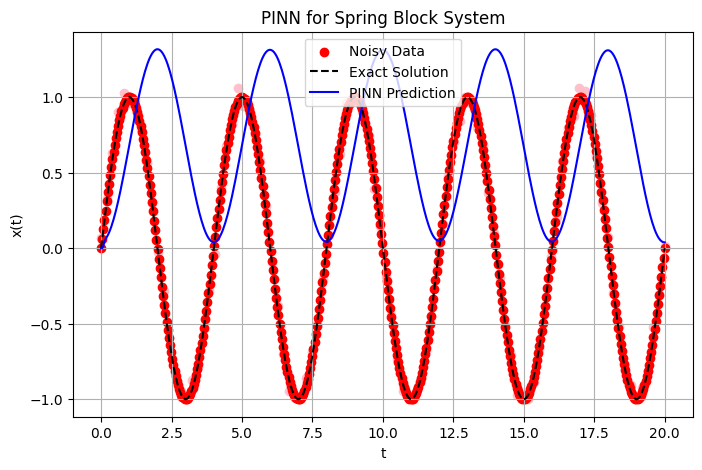

In [15]:
model.eval()
t_plot = np.linspace(0, 20, 500).reshape(-1,1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
x_pred_plot = model(t_plot_tensor).detach().numpy()

x_true_plot = spring_block_system(t_plot)

plt.figure(figsize=(8, 5))
plt.scatter(t_actual,noisy_data,c="pink")
plt.scatter(t_plot, x_true_plot, color='red', label='Noisy Data')
plt.plot(t_plot, x_true_plot,'k--',label='Exact Solution')
plt.plot(t_plot, x_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.title('PINN for Spring Block System')
plt.grid(True)
plt.show()

In [16]:
import numpy as np

error = np.linalg.norm(x_pred_plot - x_true_plot, 2) / np.linalg.norm(x_true_plot, 2)
accuracy = 1 - error
print("Relative L2 Error:", error)
print("Accuracy:", accuracy)

Relative L2 Error: 1.5187279
Accuracy: -0.5187278985977173
